<a href="https://colab.research.google.com/github/kellyegorman/UNet-DenseNet-Blog/blob/main/make_hdf5_synthetic_circles_and_boxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dataname="synthetic"

patch_size=256 #size of the tiles to put into DB
data_size=[10000,100]
balance=.5
classes=[0,1] #what classes we expect to have in the data, in this case data without boxes and data with boxes

max_circles=10
max_squares=1
diameter_min=10
diameter_max=50

phases=["train","val"]

In [ ]:
import random
import tables
import sys

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw


seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 7767147592313434056


In [ ]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%ls MyDrive/

'BCG Notes.gdoc'
'Bloomberg Forum.gdoc'
'Christmas 2023 :).gslides'
'Christmas List.gdoc'
 Classroom/
'Colab Notebooks'/
 Colab_Notebooks/
'COURSE PLANNING!.gsheet'
'Critiques Week 2.gdoc'
'CSDS 132 Midterm Review .gdoc'
'CSDS 133 NOTES.gdoc'
'CSDS 233 NOTES.gdoc'
'CSDS234 Lecture Notes.pdf'
'CSDS 234 Project To-Do.gdoc'
'Data Science Statistics Intern Cover Letter.gdoc'
'DELOITTE MTG.gdoc'
'DenseNet Lymphoma Slides - Kelly Gorman.gslides'
'DenseNet Model Results.gslides'
'dresses and clothes comp.gsheet'
'DSC - Comparison Between Models.gsheet'
'DSCI 330 Notes.gdoc'
 E05F31F3-6443-4956-B0BF-038FD1615EB9.jpeg
'E2 Chem Review Topics.gdoc'
'Elfreda Chatman-Walter Speaker Reflection.gdoc'
'ENGL 213 Coming Out story.gdoc'
 epistroma_results.gslides
 epistroma_results.pptx
'ESC2 FINAL.gdoc'
'Esc 3 Final.gdoc'
'Escritura 2.gdoc'
'Exam 2 Chem SI Review!!!.gdoc'
'EXAM 2 CHEM SI Sessions.gdoc'
 Fall2023-Pre-survey.gdoc
 GoodNotes/
 Gorman_BigData.gdoc
'Gorman, Kelly- Transfer Credit Approval Fo

In [ ]:
%cd /gdrive/MyDrive/PytorchDigitalPathology/visualization_densenet

/gdrive/MyDrive/PytorchDigitalPathology/visualization_densenet


In [ ]:
%matplotlib inline
storage={} #holder for future pytables

block_shape=np.array((patch_size,patch_size)) #block shape specifies what we'll be saving into the pytable array, here we assume that masks are 1d and images are 3d

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed


for phase,nimgs in zip(phases,data_size): #now for each of the phases, we'll loop through the files
    print(phase)

    totals=np.zeros(2) # we can to keep counts of all the classes in for in particular training, since we

    hdf5_file = tables.open_file(f"./{dataname}_{phase}.pytable", mode='w') #open the respective pytable


    storage["imgs"]= hdf5_file.create_earray(hdf5_file.root, "imgs", img_dtype,
                                              shape=np.append([0],block_shape),
                                              chunkshape=np.append([1],block_shape),
                                              filters=filters)
    storage["labels"]= hdf5_file.create_earray(hdf5_file.root, "labels", img_dtype,
                                              shape=[0],
                                              chunkshape=[1],
                                              filters=filters)


    for filei in range(nimgs): #now for each of the files
        img=np.zeros((patch_size,patch_size))
        img = Image.fromarray(img)
        draw= ImageDraw.Draw(img)

        for i in range(np.random.randint(0,high=max_circles)):
            d=np.random.randint(diameter_min,diameter_max)
            ul=np.random.randint(diameter_min,patch_size-diameter_max,2)
            draw.ellipse(list(np.append(ul,ul+d)),fill=255)


        label=np.random.random()>balance
        if label:
            for i in range(np.random.randint(1,high=max_squares+1)):
                d=np.random.randint(diameter_min,diameter_max)
                ul=np.random.randint(diameter_min,patch_size-diameter_max,2)
                draw.rectangle(list(np.append(ul,ul+d)),fill=255)
                totals[1]+=1
        else:
            totals[0]+=1
            #add square

        del draw

        storage["imgs"].append(np.array(img)[None,::])
        storage["labels"].append([np.uint8(label)]) #add the filename to the storage array

    #lastely, we should store the number of pixels
    npixels=hdf5_file.create_carray(hdf5_file.root, 'classsizes', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

print("done")

train
val
done


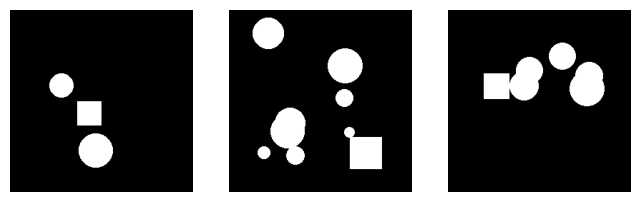

In [ ]:
import numpy as np
import tables
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Load the stored data
hdf5_file = tables.open_file(f"./{dataname}_{phase}.pytable", mode='r')

# Extract stored images and labels
imgs = hdf5_file.root.imgs[:]
labels = hdf5_file.root.labels[:]

# Select two random indices
indices = np.random.choice(len(imgs), 3, replace=False)

# Display the two images
fig, axes = plt.subplots(1, 3, figsize=(8, 4))

for i, idx in enumerate(indices):
    axes[i].imshow(imgs[idx], cmap="gray")  # Display as grayscale
    # axes[i].set_title(f"Label: {labels[idx][0]}")
    axes[i].axis("off")

plt.show()

# Close the HDF5 file
hdf5_file.close()